In [1]:
import numpy as numpy
import torch
import sys
sys.path.append("../")
from model_continues_mode_tensor import Continues_Mode_Tensor_CP
import utils_continues
import yaml
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt

torch.random.manual_seed(300)
# load config
args = None


config_path = "./config_synthetic_CP.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

data_path = config["data_path"]

# prepare hyper_dict and data_dict

hyper_dict = utils_continues.make_hyper_dict(config, args)
data_dict = utils_continues.make_data_dict(hyper_dict, data_path,0)

EPOCH = hyper_dict["epoch"]

test_rmse = []
test_MAE = []

result_dict = {}
start_time = time.time()

# model
model = Continues_Mode_Tensor_CP(hyper_dict, data_dict)




use device: cpu


In [2]:
for epoch in tqdm.tqdm(range(EPOCH)):

    # reset LDS
    model.reset()

    # approx the msg from data-llk by standard CEP
    # LDS update:filter + smooth

    if hyper_dict['CEP_UPDATE_INNNER_MODE'] == True:
        for mode in range(model.nmods):
            model.msg_approx_U(mode)

            # LDS update:filter + smooth
            model.LDS_update(mode)
            # posterior update based on LDS-result
            model.post_update_U(mode)

    else:
        for mode in range(model.nmods):
            model.msg_approx_U(mode)

            # LDS update:filter + smooth
        for mode in range(model.nmods):
            # LDS update:filter + smooth
            model.LDS_update(mode)
            # posterior update based on LDS-result
            model.post_update_U(mode)

    model.msg_approx_tau()
    model.post_update_tau()



    if hyper_dict["EVALU_EPOCH"] > 0:

        if epoch % hyper_dict["EVALU_EPOCH"] == 0:

            pred, train_result = model.model_test(model.tr_ind_DISCT,
                                                model.tr_y)

            model.post_merge_U()

            pred, test_result = model.model_test(model.te_ind_DISCT,
                                                model.te_y)

            print("epoch:", epoch,
                "train-rmse:%.3f" % train_result['rmse'],
                "test-rmse::%.3f" % test_result['rmse'])
model.post_merge_U()
pred, test_result = model.model_test(model.te_ind_DISCT, model.te_y)
print("final test-error, RMSE: %.3f, MAE: %.3f"%(test_result['rmse'].cpu().numpy().squeeze(),test_result['MAE'].cpu().numpy().squeeze()))

  2%|▏         | 2/100 [00:00<00:08, 11.11it/s]

epoch: 0 train-rmse:0.061 test-rmse::0.066


 32%|███▏      | 32/100 [00:02<00:05, 12.47it/s]

epoch: 30 train-rmse:0.003 test-rmse::0.004


 62%|██████▏   | 62/100 [00:05<00:03, 12.48it/s]

epoch: 60 train-rmse:0.003 test-rmse::0.004


 92%|█████████▏| 92/100 [00:07<00:00, 12.50it/s]

epoch: 90 train-rmse:0.003 test-rmse::0.004


100%|██████████| 100/100 [00:08<00:00, 12.44it/s]

final test-error, RMSE: 0.004, MAE: 0.002


In [3]:




U1_traj_pred = model.post_U_m[0].squeeze().cpu().numpy()
U2_traj_pred = model.post_U_m[1].squeeze().cpu().numpy()


U1_traj_pred_v = model.post_U_v[0].squeeze().cpu().numpy()
U2_traj_pred_v = model.post_U_v[1].squeeze().cpu().numpy()

# U1_traj_pred_v = np.sqrt(U1_traj_pred_v)
# U2_traj_pred_v = np.sqrt(U2_traj_pred_v)

U1_traj_pred_v = U1_traj_pred_v*3
U2_traj_pred_v = U2_traj_pred_v*3

post_U = {}
post_U['U1_traj_pred'] = U1_traj_pred
post_U['U2_traj_pred'] = U2_traj_pred

post_U['U1_traj_pred_v'] = U1_traj_pred_v
post_U['U2_traj_pred_v'] = U2_traj_pred_v

# np.save('./post_U.npy',post_U)

U1_idx = np.array(list(data_dict['CONTI_2_DISCT_dicts'][0].keys()))
U2_idx = np.array(list(data_dict['CONTI_2_DISCT_dicts'][1].keys()))

U1_traj_true = data_dict['U1_traj_true']
U2_traj_true = data_dict['U2_traj_true']


X_train = data_dict['X_train']
Y_train = data_dict['Y_train']
Z_train = data_dict['Z_train']

N = len(X_train)
real_train = int(N*0.5)
real_train_idx = np.random.choice(N,real_train,replace=False)
X_train = X_train[real_train_idx]
Y_train = Y_train[real_train_idx]
Z_train = Z_train[real_train_idx]


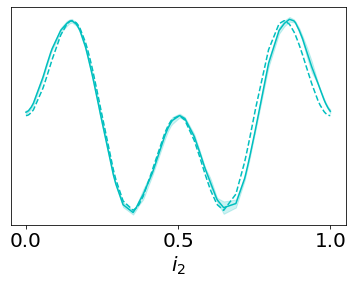

In [4]:
plt.subplots( 1,1,figsize=(6, 4))

plt.plot(U1_idx,U1_traj_pred,'c',label='Learned')

plt.fill_between(U1_idx,U1_traj_pred-U1_traj_pred_v,  U1_traj_pred+U1_traj_pred_v, alpha=0.2, color='c')

plt.plot(U1_idx,U1_traj_true,'c--',label='U1-traj-true')

plt.xlabel('$i_2$',fontsize=20)

_ = plt.yticks([], [])
_ = plt.xticks([0.0,0.5,1.0],fontsize=20)

file_name = 'figs/simu_CP_U2_traj.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")


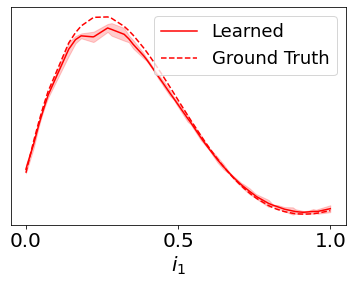

In [5]:
plt.subplots( 1,1,figsize=(6, 4))

plt.plot(U2_idx,U2_traj_pred,'r',label='Learned')
plt.plot(U2_idx,U2_traj_true,'r--', label='Ground Truth')

plt.fill_between(U2_idx,U2_traj_pred-U2_traj_pred_v,   U2_traj_pred+U2_traj_pred_v, alpha=0.2, color='r')

plt.xlabel('$i_1$',fontsize=20)
_ = plt.yticks([], [])
_ = plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.legend( loc='upper right',fontsize=18)
file_name = 'figs/simu_CP_U1_traj.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")

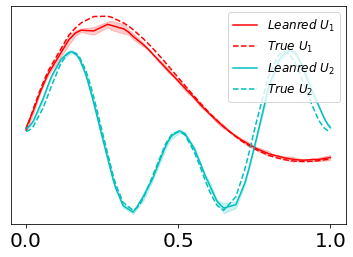

In [6]:

plt.subplots( 1,1,figsize=(6, 4))

plt.plot(U2_idx,U2_traj_pred,'r',label='$Leanred \    U_1 $')
plt.plot(U2_idx,U2_traj_true,'r--', label='$True \    U_1 $')

plt.plot(U1_idx,U1_traj_pred,'c',label='$Leanred \    U_2$')

plt.fill_between(U1_idx,U1_traj_pred-U1_traj_pred_v,  U1_traj_pred+U1_traj_pred_v, alpha=0.2, color='c')

plt.plot(U1_idx,U1_traj_true,'c--',label='$True \    U_2$')


_ = plt.yticks([], [])
_ = plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.fill_between(U2_idx,U2_traj_pred-U2_traj_pred_v,   U2_traj_pred+U2_traj_pred_v, alpha=0.2, color='r')

plt.legend(fontsize=12,loc='upper right')

file_name = 'figs/simu_CP_U1_U2.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")

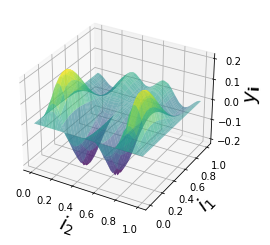

In [16]:
lam_U1 = lambda t:np.sin(t*2*np.pi)*np.cos(t*2*np.pi)*np.sin(t*2*np.pi)
lam_U5 = lambda t:np.exp(-2*t) * ((np.sin(t*1.5*np.pi)))



def f(x, y):
    return lam_U1(x)*lam_U5(y)
x = U1_idx
y = U2_idx
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
# fig = plt.figure(figsize=(6, 4))
ax = plt.axes(projection='3d')
# ax = fig.add_subplot(projection='3d')


ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
                cmap='viridis', edgecolor='none', alpha=0.6)

ax.set_xlabel('$i_2$',fontsize=20)
ax.set_ylabel('$i_1$',fontsize=20)
ax.set_zlabel('$y_{\mathbf{i}}$',fontsize=20);
# plt.show()

file_name = 'figs/simu_true_surface.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")

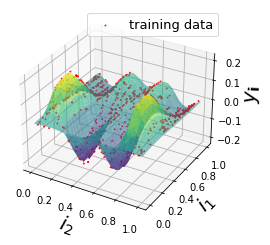

In [15]:


def f_pred(X, Y):

    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):

            x = X[i,j]
            y = Y[i,j]
            id_U1 = data_dict['CONTI_2_DISCT_dicts'][0][x]
            id_U2 = data_dict['CONTI_2_DISCT_dicts'][1][y]       

            Z[i,j] = U1_traj_pred[id_U1] * U2_traj_pred[id_U2] 

    return Z

x = U1_idx
y = U2_idx
X, Y = np.meshgrid(x, y)
Z = f_pred(X, Y)

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
                cmap='viridis', edgecolor='none', alpha=0.6)

ax.scatter(X_train.reshape(-1), Y_train.reshape(-1),  Z_train.reshape(-1), c='red', marker='o', s=1,alpha=0.8, label='training data');

# ax.set_title('Predicted Landscape');


ax.set_xlabel('$i_2$',fontsize=20)
ax.set_ylabel('$i_1$',fontsize=20)
ax.set_zlabel('$y_{\mathbf{i}}$',fontsize=20);

ax.legend(fontsize=13)

file_name = 'figs/simu_pred_surface.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")


